In [84]:
import sys
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from data_helper import *

config = configparser.ConfigParser()
config.read('config/mypredictorconfig.ini')

eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [85]:
# Model reconstruction from JSON file
weight_name = config['infiles']['weight_name']
arch_name = config['infiles']['arch_name']

with open(arch_name, 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(weight_name)



In [86]:
look_back = config['MODEL']['look_back']
anomaly_threshold = int(config['MODEL']['anomaly_threshold'])
look_back = int(config['MODEL']['look_back'])

In [87]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = '2019-07-28', end = end, calculation = calculation, interval= interval)

Grabbing WebIDs ...
WebID collection complete!
13:28:52: Sending API request... Chunk 1 of 1
13:28:52: Response recieved for 2 tags! (0.04)


In [88]:
df = create_standard_multivariable_df(df, shift = look_back)

Generated: 49 columns


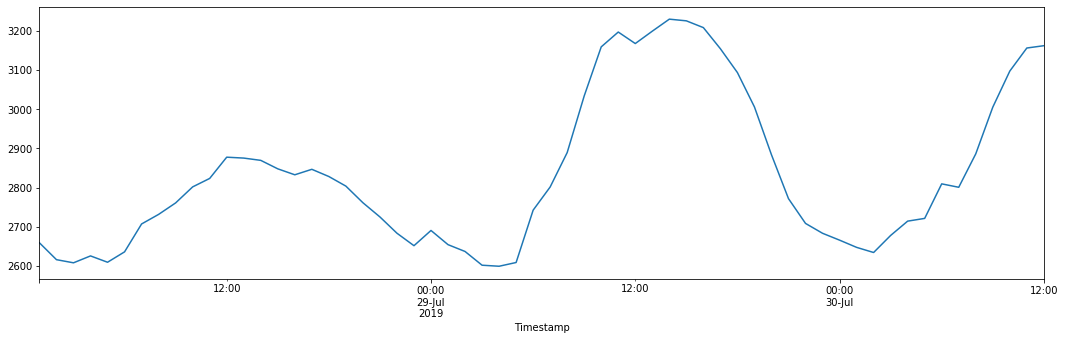

In [89]:
df[point_name].plot(figsize = (18,5))

In [90]:
y = df[point_name]
X = df.drop(columns=point_name)

In [91]:
scaler = MinMaxScaler(feature_range=(0,1))

X_test = scaler.fit_transform(X)
y_test = scaler.fit_transform(np.array(y).reshape((-1,1)))


In [92]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [93]:
prediction = model.predict(X_test)

In [94]:
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [95]:
prediction = prediction

In [96]:
index = df.index

<Figure size 1296x144 with 0 Axes>

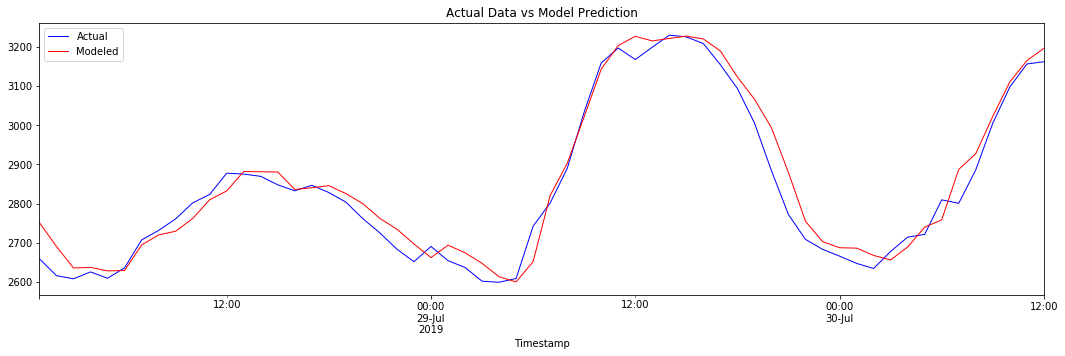

In [97]:
plt.figure(figsize=(18,2))
result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=index)

result.plot(figsize=(18,5),
                         title="Actual Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])

In [98]:
pc.search_by_point('*outside*forecast*')

['Outside_Air_Temp_Forecast']

In [99]:
#result.set_index(index, inplace = True)

In [100]:
result.eval('Difference = (Actual - Modeled)/ Actual * 100', inplace=True)

#result["Difference"] = result['Actual'] - result['Modeled']
result["Difference"] = result['Difference'].abs().round(decimals = 2)

In [101]:
result.head()

,Actual,Modeled,Difference
Timestamp,,,
2019-07-28 01:00:00,2658.789846,2751.083008,3.47
2019-07-28 02:00:00,2615.727010,2690.242432,2.85
2019-07-28 03:00:00,2607.721415,2635.387695,1.06
2019-07-28 04:00:00,2625.336609,2636.871826,0.44
2019-07-28 05:00:00,2609.168396,2627.916748,0.72


In [102]:
actual = result['Actual'].tolist()
modeled = result['Modeled'].tolist()
difference = result['Difference'].tolist()
idx = result.index.tolist()
ymax = max(max(actual, modeled))
ymin = min(min(actual, modeled))

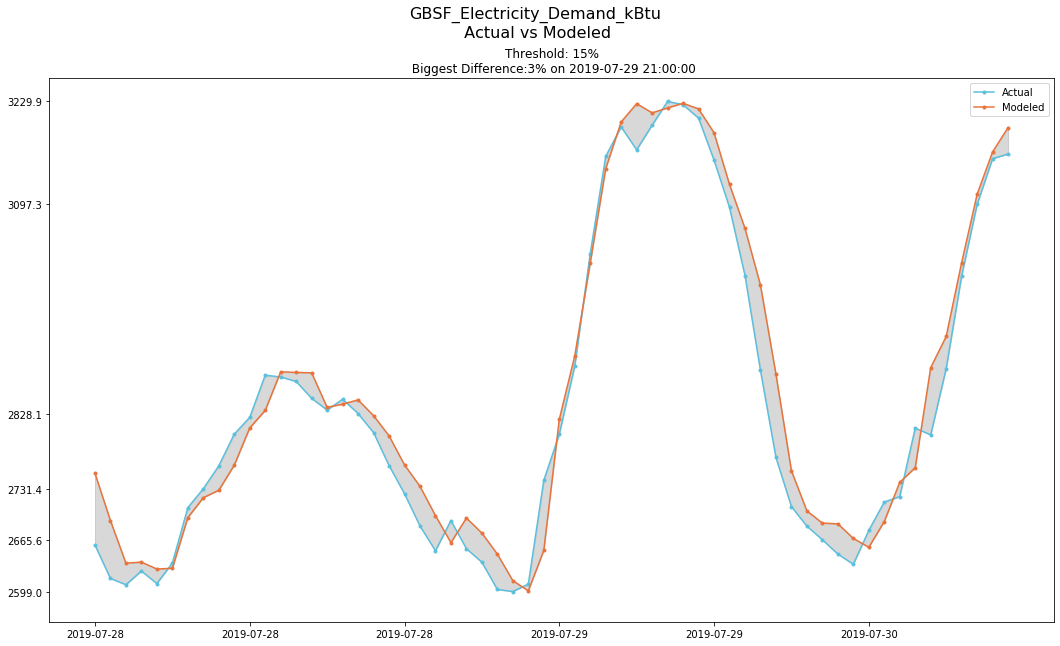

In [103]:
plt.figure(figsize=(18,10))
count = 1
for ii in range(len(actual)):
    
    if difference[ii] > anomaly_threshold:
        if count%2 == 0:
            plt.text(idx[ii] , ymin*0.99, int(difference[ii]), size = 11)
            count = count +1
        else:
            plt.text(idx[ii] , ymin*1.00, int(difference[ii]), size = 11)
            count = count +1
        plt.axvline(x = idx[ii], color = 'r', linestyle = '--')
plt.plot(idx, actual, marker = ".", color="#5bc0de", label = 'Actual')
plt.plot(idx, modeled, marker = ".", color="#E8743B", label = "Modeled")

plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(idx, actual, modeled, color = "grey", alpha = "0.3")
plt.yticks(actual, size= 10)
plt.xticks(idx, size = 10)

plt.locator_params(axis = 'y', tight = True, nbins=6)
plt.locator_params(axis = 'x', nbins = 6)
biggest_difference = result.loc[result['Difference'] == max(difference)]['Difference'][0]
at_time = result.loc[result['Difference'] == max(difference)].index[0]
plt.suptitle(f"{point_name}\n Actual vs Modeled", fontsize = 16)
plt.title(f"Threshold: {anomaly_threshold}%\n Biggest Difference:{int(biggest_difference)}% on {at_time}")
plt.legend()
plt.show()